In [8]:
from rdflib import ConjunctiveGraph
from jinja2 import Template
import seaborn as sns 
import matplotlib.pyplot as plt
import json
from pyshacl import validate
from IPython.display import display, Markdown, Latex

from crawl_and_lift import rdfize, crawl_bioagents
import urllib3
import requests

%matplotlib inline

# 1. Mapping bio.agents to BioSchemas.org terms

In [9]:
mapping_attributes_bioschema = {}
mapping_attributes_bioschema['name'] = "schema:name" #done
mapping_attributes_bioschema['description'] = "schema:description" #done
mapping_attributes_bioschema['homepage'] = "schema:url" #done
#mapping_attributes_bioschema['bioagentsID'] = ""
#mapping_attributes_bioschema['bioagentsCURIE'] = ""
mapping_attributes_bioschema['agentType'] = "schema:additionalType" #done
mapping_attributes_bioschema['topic'] = "schema:applicationSubCategory" #done
mapping_attributes_bioschema['cost'] = "schema:isAccessibleForFree" #done
mapping_attributes_bioschema['publicationPrimary'] = "schema:citation" #done
mapping_attributes_bioschema['creditprimaryContact'] = "bioagents:primaryContact" #done
mapping_attributes_bioschema['operation'] = "schema:featureList" #done
mapping_attributes_bioschema['inputData'] = "edam:has_input" #done
mapping_attributes_bioschema['outputData'] = "edam:has_output" #done
mapping_attributes_bioschema['operatingSystem'] = "schema:operatingSystem" #done
mapping_attributes_bioschema['license'] = "schema:license" #done
mapping_attributes_bioschema['apiDocumentation'] = "schema:softwareHelp" #done
mapping_attributes_bioschema['generalDocumentation'] = "schema:softwareHelp" #done
#mapping_attributes_bioschema['commandlineOptions'] = "bioagents:commandlineOptions" # any availabe ?
mapping_attributes_bioschema['termsOfUse'] = "schema:termsOfService" # any availabe ?

# 2. Loading the information profile and replacing attributes with BioSchemas terms

In [10]:
mandatory_rules = []
with open('../profiles/ifbAgentInfoProfile.json', 'r') as f:
    profile = json.load(f)
for r in profile['rules']:
    if 'Mandatory' in r['requirement']:
        print(r)
        std_attributes = []
        for at in r['attributes']: 
       # 1. Loading an information profile     if at in mapping_attributes_bioschema.keys():
                if at in mapping_attributes_bioschema.keys():
                    std_attributes.append(mapping_attributes_bioschema[at])
        r['attributes']=std_attributes
        print(r)
        mandatory_rules.append(r)
        print()
        print()

{'attributes': ['name', 'description', 'homepage', 'bioagentsID', 'bioagentsCURIE', 'agentType', 'topic', 'cost', 'publicationPrimary', 'creditprimaryContact'], 'constraint': 'all', 'types': ['Command-line agent', 'Desktop application', 'Web application', 'Database portal', 'Bioinformatics portal'], 'requirement': 'Mandatory', 'comment': 'MANDATORY attributes for ALL main 5 agent types'}
{'attributes': ['schema:name', 'schema:description', 'schema:url', 'schema:additionalType', 'schema:applicationSubCategory', 'schema:isAccessibleForFree', 'schema:citation', 'bioagents:primaryContact'], 'constraint': 'all', 'types': ['Command-line agent', 'Desktop application', 'Web application', 'Database portal', 'Bioinformatics portal'], 'requirement': 'Mandatory', 'comment': 'MANDATORY attributes for ALL main 5 agent types'}


{'attributes': ['operation'], 'types': ['Command-line agent', 'Desktop application', 'Web application', 'Database portal'], 'requirement': 'Mandatory'}
{'attributes': ['schem

# 3. Generating a SHACL shape from a list of mandatory properties

In [11]:
shape_template = """
@prefix dash: <http://datashapes.org/dash#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <http://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix edam: <http://edamontology.org/> .
@prefix bioagents: <https://bio.agents/ontology/> .

{% for rule in rules %}
schema:AgentShape
    a sh:NodeShape ;
    sh:targetClass schema:SoftwareApplication ;

    sh:filterShape [
        sh:property [
            sh:path schema:additionalType ;
            sh:in ( {% for type in rule['types'] %} "{{ type }}" {% endfor %} ) ;
        ] ;
    ] ;

    {% for prop_name in rule['attributes'] %}
    sh:property [
        sh:path {{prop_name}} ;
        sh:minCount 1 ;
    ] ;
    {% endfor %}
    .
{% endfor %}
"""

template = Template(shape_template)
shape = template.render(rules=mandatory_rules)
print(shape)
g = ConjunctiveGraph()
g.parse(data = shape, format='turtle')
print(len(g))


@prefix dash: <http://datashapes.org/dash#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <http://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix edam: <http://edamontology.org/> .
@prefix bioagents: <https://bio.agents/ontology/> .


schema:AgentShape
    a sh:NodeShape ;
    sh:targetClass schema:SoftwareApplication ;

    sh:filterShape [
        sh:property [
            sh:path schema:additionalType ;
            sh:in (  "Command-line agent"  "Desktop application"  "Web application"  "Database portal"  "Bioinformatics portal"  ) ;
        ] ;
    ] ;

    
    sh:property [
        sh:path schema:name ;
        sh:minCount 1 ;
    ] ;
    
    sh:property [
        sh:path schema:description ;
        sh:minCount 1 ;
    ] ;
    
    sh:property [
        sh:path schema:url ;
        sh:minCount 1 ;
    ] ;
    
    sh:pro

# 4. Validating sample agents

In [12]:
agent_id = "workflow4metabolomics"
#agent_id = "raiss"
#agent_id = "Ocean_Gene_Atlas"
#agent_id = "varaft"

url = 'https://bio.agents/api/agent/'+agent_id+'?format=json'

r = requests.get(url)
agent = r.json()

#print(json.dumps(rdfize(agent), indent=4))

data_agent = ConjunctiveGraph()
data_agent.parse(data = rdfize(agent), format="json-ld")

print(data_agent.serialize(format="turtle").decode())

r = validate(data_graph = data_agent, 
             data_graph_format='turtle', 
             shacl_graph = shape, 
             #shacl_graph = my_shacl_constraint,
             shacl_graph_format = 'turtle', 
             ont_graph = None, 
             inference = 'rdfs', 
             abort_on_error = False, 
             meta_shacl = False, 
             debug = True)

conforms, results_graph, results_text = r

report_query = """
    SELECT ?node ?path WHERE {
        ?v rdf:type sh:ValidationReport ;
           sh:result ?r .
        ?r sh:focusNode ?node ;
           sh:sourceShape ?s . 
        ?s sh:path ?path . 
    }
"""

results = results_graph.query(report_query)
for r in results :
    display(Markdown('The agent `{}` should be fixed, it is missing information for field {}'.format(str(r['node']), str(r['path']))))
    #display(Markdown(' **It was produced in the context of** ' + str(r['st']) ))
    
print(str(len(results))+ ' actions needed to fix mandatory')

#print(results_text)

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/workflow4metabolomics>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/workflow4metabolomics>
	Result Path: schema:license



@prefix bioagents: <https://bio.agents/ontology/> .
@prefix bsc: <http://bioschemas.org/> .
@prefix edam: <http://edamontology.org/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sc: <http://schema.org/> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<https://bio.agents/workflow4metabolomics> a sc:SoftwareApplication ;
    edam:has_input edam:data_0943,
        edam:data_3488 ;
    sc:additionalType "Bioinformatics portal" ;
    sc:applicationSubCategory edam:topic_2259,
        edam:topic_3172,
        edam:topic_3307 ;
    sc:author <https://orcid.org/0000-0001-8177-4873>,
        "Jean-François Martin",
        "Marion Landi",
        "Misharl Monsoor",
        "Mélanie Pétéra",
        "Pierre Pericard" ;
    sc:citation <https://doi.org/10.1016/j.biocel.2017.07.002>,
        <https://doi.org/10.1093/bioinformatics/btu813> ;
    sc:contributo

The agent `https://bio.agents/workflow4metabolomics` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/workflow4metabolomics` should be fixed, it is missing information for field http://schema.org/license

2 actions needed to fix mandatory


# 5. Validating the shape on the SDP graph data

In [6]:
from pyshacl import validate
from IPython.display import display, Markdown, Latex

sdp = "iechor-fr-sdp-2019"
data = crawl_bioagents(collection=sdp)

print(len(g))
#g.serialize(format='turtle', destination='sdp.bioagents.bioschema.ttl')
#print('BioSchema output produced at sdp.bioagents.bioschema.ttl')
#g.serialize(format='json-ld', auto_compact=True, destination='sdp.bioagents.bioschema.json-ld')
#print('BioSchema output produced at sdp.bioagents.bioschema.json-ld')

#data = ConjunctiveGraph()
#data.parse("./sdp.bioagents.bioschema.ttl", format='turtle')
#print(len(data))

r = validate(data_graph = data, 
             data_graph_format='turtle', 
             #shacl_graph = manual_shape_constraint, 
             shacl_graph = shape, 
             shacl_graph_format = 'turtle', 
             ont_graph = None, 
             inference = 'rdfs', 
             abort_on_error = False, 
             meta_shacl = False, 
             debug = False)

conforms, results_graph, results_text = r

#if not conforms:
#    print(results_graph.serialize(format='turtle').decode())
#else:
#    print('Everything is fine')

17148 available BioAgents entries
138


# 6. Producing an explaination for the validation graph

In [24]:
report_query = """
    SELECT ?node ?path WHERE {
        ?v rdf:type sh:ValidationReport ;
           sh:result ?r .
        ?r sh:focusNode ?node ;
           sh:sourceShape ?s . 
        ?s sh:path ?path . 
    }
"""

results = results_graph.query(report_query)
for r in results :
    display(Markdown('The agent `{}` should be fixed, it is missing information for field {}'.format(str(r['node']), str(r['path']))))
    #display(Markdown(' **It was produced in the context of** ' + str(r['st']) ))
    
print(str(len(results))+ ' actions needed to fix mandatory description in iEchor-FR service delivery plan')

The agent `https://bio.agents/lordec` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/BISE` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/rsat` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/Cocoa_Genome_Hub` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/rsat` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/WheatIS` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field http://schema.org/additionalType

The agent `https://bio.agents/gnpis` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/WheatIS` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/metexplore` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/phylogeny.fr` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/BISE` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-protists` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-Plants` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/matrixdb` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/Genomicus-metazoa` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/phylogeny.fr` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://schema.org/featureList

The agent `https://bio.agents/GENOMICUS` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/imgt` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Ocean_Gene_Atlas` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/Genomicus-fungi` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/lordec` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/rsat` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/gnpis` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/GENOMICUS` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/imgt` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/workflow4metabolomics` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/ginsim` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Banana_Genome_Hub` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/featureList

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/Lifemap` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/Genomicus-fungi` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/matrixdb` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/phylogeny.fr` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://schema.org/featureList

The agent `https://bio.agents/lordec` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/phylogeny.fr` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/featureList

The agent `https://bio.agents/lordec` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Sugarcane_Genome_Hub` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://schema.org/featureList

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/Genomicus-Plants` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/varaft` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/WheatIS` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/ginsim` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/GENOMICUS` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/Rice_Genome_Hub` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/BISE` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/phylogeny.fr` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/MicroScope_platform` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/metexplore` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/Ocean_Gene_Atlas` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/GENOMICUS` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/WheatIS` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/Sugarcane_Genome_Hub` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/matrixdb` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/imgt` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/MicroScope_platform` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/aureme` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Rice_Genome_Hub` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/MicroScope_platform` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/rsat` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/workflow4metabolomics` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/aria` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/repet` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/matrixdb` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/additionalType

The agent `https://bio.agents/WheatIS` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/phyml` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-metazoa` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/matrixdb` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/MicroScope_platform` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/parameciumdb` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/varaft` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/oligo-analysis` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/gnpis` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/CRISPRCas` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Genomicus-Plants` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Genomicus-protists` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Rice_Genome_Hub` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/Cocoa_Genome_Hub` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/Lifemap` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/RSAT-position-analysis` should be fixed, it is missing information for field http://schema.org/termsOfService

The agent `https://bio.agents/Genomicus-metazoa` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/citation

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/featureList

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/lordec` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/imgt` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/Genomicus-protists` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/SouthGreen` should be fixed, it is missing information for field http://schema.org/featureList

The agent `https://bio.agents/repet` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/WheatIS` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://schema.org/additionalType

The agent `https://bio.agents/aureme` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/gnpis` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/GENOMICUS` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/GalaxyCat` should be fixed, it is missing information for field http://edamontology.org/has_output

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/Galaxy_Pasteur` should be fixed, it is missing information for field http://edamontology.org/has_input

The agent `https://bio.agents/SulfAtlas` should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent `https://bio.agents/Genomicus-fungi` should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent `https://bio.agents/NORINE` should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent `https://bio.agents/imgt` should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent `https://bio.agents/SouthGreen_Galaxy` should be fixed, it is missing information for field http://schema.org/featureList

The agent `https://bio.agents/GalaxEast` should be fixed, it is missing information for field http://schema.org/license

The agent `https://bio.agents/MicroScope_platform` should be fixed, it is missing information for field http://schema.org/termsOfService

199 actions needed to fix mandatory description in iEchor-FR service delivery plan


# 7. (long) Launching the validation on a large dataset

In [26]:
%%time

data = crawl_bioagents(limit=1000)
print(len(data))
data.serialize(format='turtle', destination='test.bioagents.bioschema.ttl')

r = validate(data_graph = 'test.bioagents.bioschema.ttl', 
             data_graph_format='turtle', 
             shacl_graph = shape, 
             shacl_graph_format = 'turtle', 
             ont_graph = None, 
             inference = 'rdfs', 
             abort_on_error = False, 
             meta_shacl = False, 
             debug = True)

conforms, results_graph, results_text = r

results = results_graph.query(report_query)
for r in results :
    display(Markdown('The agent {} should be fixed, it is missing information for field {}'.format(str(r['node']), str(r['path']))))

print(str(len(results))+ ' actions needed to fix mandatory description bio.agents')

17147 available BioAgents entries
3 % done
6 % done
15186


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/Genomicus-tunicates>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/IMGT_HighV-QUEST>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/Mann-Kendall>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/GE_LDA_Survival>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PACKMAN>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/disco_autogenerated>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/RHPCG>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/HILJ>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/B88>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severit

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/open-data>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PCA>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/SIRM>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Sev

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/tree_shape_statistics>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/scMNase-seq>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/Topological_Tumor_Graphs>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/nanopore>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/diffGrad>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/Paragraph_autogenerated>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/NeoPeptide>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/ICGRM>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/TestIME>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent)

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/pyPESTO>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/NeuroPostureApp>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/B86>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/RRphylo>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/SEQdata-BEACON>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/CMAC>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/CeutaOPEN>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/TabSINT>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/org>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/ParLECH>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/tsMSQ>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PATHFx>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	S

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/NmSEER_V2.0>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PhySpeTree>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/IDH1mut_cancers>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/yakusa>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/DIME>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PSI-SMALP>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/9aaTAD>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/patents>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/withdrawal>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/eQTL>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/mrdna>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/CCC-Agent>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	S

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/scReClassify>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PHENOSTAMP>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/TM3_seq>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/LinkPhinder>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/RNAactDrug>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/deBGA-VARA>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PASTMUS>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/geoportalgasolineras>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/Mobilum>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/SSnet>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/microscopemage>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/publicly-available>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConst


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/GroScore>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/data-driven_materials_science>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/meta-analysis_rare_variant>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PIRCh-seq>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/GSEA_autogenerated>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/PhyDL_autogenerated>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/pirouette>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/UPObase>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/OPD>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/Natural_Products_Atlas>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/VGE>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:license ]
	Focus Node: <https://bio.agents/directors>
	Result Path: schema:license

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/SAXSDom>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/VSAQs>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/x-mate>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/PACKMAN>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/disco_autogenerated>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/iMED>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/ssNPA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/gazecom_annotations>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/VariantStore>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/pancancer>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/aesthetic_damage>
	Result Path: schema:operatingSystem

Constraint 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/CATHER>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/CBNA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/DDIGIP>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/scale-up>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/FXD-CSD-GUI>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/mpss>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/action>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/GABAC>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/ctmmweb>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/DEPICTER>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/25000_ug_BPA_kg_bw>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/HOPS_autogenerated>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/SLNPM-SC_SLNPM-PC>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/PySpacell>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/Halobenzenes_Xylenes>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/PiVR>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/NUMT>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/ONDRI>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/IMGT_PhyloGene>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/qmmm>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/SAMIRIX>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/Vireo>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/DIVERCROP>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/frog2>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/epivizFileServer>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/dLsd1>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/GEDFN>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (htt

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/ABC-CT>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/RCorp>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/MiCA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/InSituAnalyze>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/EUFEMED>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/UNet>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/ProTargetMiner>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/closed-loop>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/Webina>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/IMGT_GeneInfo>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/WebAnno>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/ngsReports>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/LocPL>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/QRISK3>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/dbMMR-Chinese>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/TargetScanHuman>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/3DSlicer_autogenerated>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/eQTL>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/Phthiraptera.info>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/UNI-EM>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/getcontacts>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintCompon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/online-chem>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/SweHLA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/fpocket>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/BPRF>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/Broccoli>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/OpenProtein>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/LIMES>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/PhysMPrePro>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/TRANSNAP>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/EvolClust>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/MinION>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/LP-SDA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/PGxMine>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/SSnet>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/publicly-available>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/data-driven_materials_science>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/monores>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/meta-analysis_rare_variant>
	Result Path: schema:operatingSystem

Constraint Violation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/BeamDelta_autogenerated>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/gencore>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/FCM-m>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/PALMER>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/iProDNA-CapsNet>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/VASE>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/PANPASCO>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/PATOPA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/elastix>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/GMCLDA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/CCLA>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/TAD-Lactuca>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/Pelodiscus_sinensis>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:operatingSystem ]
	Focus Node: <https://bio.agents/BORIS>
	Result Path: schema:operatingSystem

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/VSAQs>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/tactile_glove>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/TestIME>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/NORINE>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/Phthiraptera.info>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/UNI-EM>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/Nursing>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sh

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/IsoCor>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/JUDI>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:featureList ]
	Focus Node: <https://bio.agents/fireworks>
	Result Path: schema:featureList

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCoun

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/SPLBoost>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Circle-Map>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Hass>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/B920>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/giggle>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/DeepEP>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent)

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/scifi-RNA-seq>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/DeepSV>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/RHPCG>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/linkage>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/COBRA_Agentbox>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/treeko>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/CBNA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/DDIGIP>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/sweep>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/functional_GWAS>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/COUSIN>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/scale-up>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/OpenCRG>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/SPIEC-EASI>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/GABAC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/eQTL_autogenerated>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Kaposi>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/maldsoft>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/phylomedb_v3.0>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/SiRJ>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/gvista>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/RemeDB>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/metaphors>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/VarGen>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/HaploTypo>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/wtdbg2>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/PhenX_autogenerated>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/NeuronSubtypeTranscriptomes>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Sentinel-1_SLC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/IMGT-ONTOLOGY>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/ModEx>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Transition_Scale-Spaces>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Fluor>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/RAPPAS>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/ICU_readmissions>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/PG-HACKER>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/OAC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/consensusDE>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Contrasting>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/matrixdb>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/VOCCluster>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/PSI-SMALP>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/OpenFlexure>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/iDASH>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/polyphen-2>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Genomicus-protists>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/FACEPAI>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/shotgun>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/ASD-DiagNet>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/FlyCircuit>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Jaccard>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/RocaSec>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/CellCountCV>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/plink-seq>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/mesophotic.org>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/methylCC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConst

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/PDGA_autogenerated>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Seurat_SingleR>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/GO2Vec>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/araport>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/RNAactDrug>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/deBGA-VARA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/hotspotter>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/workflow4metabolomics>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/HIV-DRLink>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/String-pulling>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/NanoCaller>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/lordec>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/publicly-available>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/FilterDCA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/scdney>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/TcellSubC>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/autoantigenomics>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/AdaTiSS>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/pest>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/AtFKBP53>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/sugsvarsel>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/COMUNET>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/OrdinalGWAS.jl>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/MADOKA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/imgt>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/DDI-PULearn>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/KBCommons>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/CCLA>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/zplan>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/TAD-Lactuca>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Pred-MutHTP>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/Pelodiscus_sinensis>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_output ]
	Focus Node: <https://bio.agents/BORIS>
	Result Path: edam:has_output

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/AlphaFamImpute>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CaptureProbe>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/National_Preparedness_Month>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/TraceMontage>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/chemfp_autogenerated>
	Result Path: schema:softwareHelp

Constraint V

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PsyMuKB>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/TRiP_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CRISPRCas>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/coil>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PRIDE_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/HistoneAnalysisWorkflow>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (h

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/tree_shape_statistics>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/scMNase-seq>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Topological_Tumor_Graphs>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/OpenCRG>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/SPIEC-EASI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/GABAC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shac

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/qmsat>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/DEPICTER>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/25000_ug_BPA_kg_bw>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/SLNPM-SC_SLNPM-PC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PySpacell>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Halobenzenes_Xylenes>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (h

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/ONDRI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/VCF2PopTree_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/deepsig>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/FunGeCo>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/XFlow>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/cgqtl>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CeutaOPEN>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/wtest>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/TabSINT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/biosciences-labs>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/ILMF-VH>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PyMOL_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/VAD_Emergency>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/RBPome>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PG-HACKER>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/VOCCluster>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/NetworkAnalyst_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/GSE64617>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (h

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/MS2CNN>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Nucleome_Data_Bank>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/MultiFRET>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/ForestQC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/qgg>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Genomicus-metazoa>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/DrOn>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/nomophobia>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Health_United_States_2017>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PCMBase>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/incarceration>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Venn-diaNet>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/TM3_seq>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/AutoEncoder>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/SpliceFinder>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Phen2Gene>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/DTA-SiST>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/scanpath>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/s

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/SimpactCyan>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/NNCI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/AACTT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/EvolClust>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/MinION>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/LP-SDA>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/publicly-available>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/FilterDCA>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/scdney>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/TcellSubC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/autoantigenomics>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/AdaTiSS>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.o

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/ASHLAR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/uslcount>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/STORM_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/MOF_coating>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/cancer_subtyping>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/NIPT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/hla-net>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Clair>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Pneumocystis>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sh

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/QuantiMus>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Kmasker_plants>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/BioMedR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:applicationSubCategory ]
	Focus Node: <https://bio.agents/withdrawal>
	Result Path: schema:applicationSubCategory

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:applicationSubCategory ]
	Focus Node: <https://bio.agents/SPROUTS>
	Result Path: schema:applicationSubCategory

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:applicationSubCategory ]
	Focus Node: <https://bio.agents/OpenProtein>
	Result Path: schema:applicationSubCategory

Constraint V

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/pathway>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/HTRgene>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/alphaimpute>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/GE_LDA_Survival>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/SNPector_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/PACKMAN>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/SingleCellSignalR>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/rKIN>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/edge-pro>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/repet>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/HapMap>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/parameciumdb>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/COBRA_Agentbox>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/treeko>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/aesthetic_damage>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/themetagenomics>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/CATHER>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/CBNA>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/scMNase-seq>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Topological_Tumor_Graphs>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/functional_GWAS>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/longitudinal_multiomic_analysis_public>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Notch>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/motoRneuron>
	Result Path: schema:termsOfService

Constraint Violation in MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/IgE-antibody_binding>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Genomicus-fungi>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/ADMMBO>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintCompo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/FConverter>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/NeoPeptide>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/tactile_glove>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/GenomicAgents_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/selsim>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/SyRI>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/NUMT>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/ONDRI>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/pyfaidx>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/HastaLaVista>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/RRphylo>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/SEQdata-BEACON>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Sentinel-1_SLC>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/IMGT-ONTOLOGY>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/STRIDE_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstrain


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/CeutaOPEN>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/arlequin>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/wtest>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/FRASER>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/SNP-CRISPR_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/DNA_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/MiCA>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/genomatix_genegrid>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/scattermore>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/InSituAnalyze>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/EUFEMED>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/UNet>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Temporal_trends_public_mass_shootings>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/clock>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/OMERO_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/iDASH>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/TWOMBLI>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Deep_Docking>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/SMART_App>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/NLP_ML>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/LPM>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/latent_Gaussian_copula_model>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/yalff_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/CYBERTRACK>
	Result Path: schema:termsOfService

Constraint Violation in MinCoun

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/mrdna>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/WHdenovo>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/CCC-Agent>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/TNFR1>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Phthiraptera.info>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/UNI-EM>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/TM3_seq>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/AutoEncoder>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/SpliceFinder>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/physician-scientists_OHSU>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/rnnimp>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/BioGears_Engine>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/SVs>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/ASA24>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/RatHat>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/CS2Structure>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Mobilum>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/LDAKM-EIoT>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/pedig>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/metabolic_pathway_prediction>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/CMVdb>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/FilterDCA>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/scdney>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/protein_model_portal>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Wang-xiaoheng>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/perfectphyloR>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/RAACBook>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (h

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/IMGT_DomainDisplay>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/popSTR2>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/BiTSC>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/AlphaBeta>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/PhyDL_autogenerated>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/CPP>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/iACetyP>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/imgt_v-quest>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/PheGWAS>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Pneumocystis>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/HIRAC>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/prosight_lite>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/VGE>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Dynamic_Meta-Storms>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/directors>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/Pelodiscus_sinensis>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:termsOfService ]
	Focus Node: <https://bio.agents/BORIS>
	Result Path: schema:termsOfService

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Genomicus-tunicates>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Circle-Map>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Hass>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Coinfinder>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/giggle>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/DeepEP>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Citrusgreening.org>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/DeepSV>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/RHPCG>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/digilogger>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/COBRA_Agentbox>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/treeko>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/aesthetic_damage>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/DDIGIP>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/sweep>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/ceRNA>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Sev

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/COUSIN>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/scale-up>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/xp-ehh>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/SPIEC-EASI>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/GABAC>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/ARGP>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/eQTL_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Kaposi>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/maldsoft>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/phylomedb_v3.0>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/SiRJ>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/gvista>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/RemeDB>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/metaphors>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/VarGen>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/HaploTypo>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/wtdbg2>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/PhenX_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/NeuronSubtypeTranscriptomes>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Sentinel-1_SLC>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/IMGT-ONTOLOGY>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sh

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/ModEx>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Transition_Scale-Spaces>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (htt

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Fluor>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/ICU_readmissions>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/RE-AIM_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/OAC>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/consensusDE>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/GEAN>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	S

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/gnpis>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/matrixdb>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/VOCCluster>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/OpenFlexure>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/iDASH>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/TWOMBLI>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/CFIR_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/OnTAD>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/deconvolution_estimate_immune_cell_subsets>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/MuPIPR>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/SigUNet>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/subgraphquant>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/GPU>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/gerp>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/come>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/miRsyn>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/NLP_autogenerated>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/FIREVAT>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/clumpak>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/SPROUTS>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/CIViCmine>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Galaxy_Pasteur>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/PICO>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/ClusPro_LigTBM>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/CpGagents>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/scPred>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/CycloNovo>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/OntoKin>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/treeld>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/pedig>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	S

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/snmf>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/GDB13>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/rgenesconverged>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/DEmiRs>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/IMGT_LocusView>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Vargas>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCompon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/ASHLAR>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/fbat>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/uslcount>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	S

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/DTSGUI>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/MaSIF>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/MOF_coating>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent)

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/HARDEN>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/mapp>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/iMIRAGE>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Se

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/Natural_Products_Atlas>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/marge>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path edam:has_input ]
	Focus Node: <https://bio.agents/VGE>
	Result Path: edam:has_input

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/ribosome_profiling>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Kaptive>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/polymarker>
	Result Path: schema:isAccessibleForFree

Constraint Violation in

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Coinfinder>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/DatView>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/survival_kit>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/MPF-BML>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/B920>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/DeepEP>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/HybridAtt>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/scifi-RNA-seq>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/DeepSV>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/linkage>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/treeko>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/aesthetic_damage>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/CATHER>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/CBNA>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/DDIGIP>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/scMNase-seq>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Topological_Tumor_Graphs>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/functional_GWAS>
	Result Path: schema:isAccessibleForFree

Constrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/longitudinal_multiomic_analysis_public>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Notch>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/motoRneuron>
	Result Path: schema:isAccessibleForFree

Cons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/selaction>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/CTS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/eQTL_autogenerated>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/ADR>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/NORINE>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/TOXcms>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/drugvirus>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/pyPESTO>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/NeuroPostureApp>
	Result Path: schema:isAccessibleForFree

Constraint Violation in Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/3DChrom>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/G-WIZ_autogenerated>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/embeddings_autogenerated>
	Result Path: schema:isAccessibleForFree

Constrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Microbe_Directory>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/cri-map>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/iQSP>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCou

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/ST-SIM>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/OCSVM>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/CeutaOPEN>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/ImPLoc>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/OMGS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/FRASER>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/SouthGreen_Galaxy>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Whisper_2>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/RestraintLib>
	Result Path: schema:isAccessibleForFree

Constraint Violation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/jhubiobank>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Bio-DIA>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/UniprotR>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/ProTargetMiner>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/closed-loop>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Webina>
	Result Path: schema:isAccessibleForFree

Constraint Violation in Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/IMGT_GeneInfo>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/WebAnno>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/ngsReports>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/LocPL>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/yrgate>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/QRISK3>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/reproduce>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/ChemDataExtractor>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/medical_relation_extraction>
	Result Path: schema:isAccessibleForFree

Const

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/omia>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/PCMBase>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/incarceration>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/scReClassify>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/impute.me>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/PHENOSTAMP>
	Result Path: schema:isAccessibleForFree

Constraint Violation in Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/hepatotoxicity>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Glyco-CPLL>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/physician-scientists_OHSU>
	Result Path: schema:isAccessibleForFree

Constrain

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/miRNA_autogenerated>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/IDEAS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/MAtCHap>
	Result Path: schema:isAccessibleForFree

Constraint Violation in Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/PASTMUS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/geoportalgasolineras>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/CS2Structure>
	Result Path: schema:isAccessibleForFree

Constraint Violatio

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/metabolic_pathway_prediction>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/CMVdb>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/AHSURED>
	Result Path: schema:isAccessibleForFree

Constraint Violati

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/snmf>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/GDB13>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/rgenesconverged>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/autoantigenomics>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/AdaTiSS>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/PathwayWP4754>
	Result Path: schema:isAccessibleForFree

Constraint Violation i

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/bkbxxmrhfh>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/pest>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/AtFKBP53>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/PALMER>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/iProDNA-CapsNet>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/VASE>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/OLGenie>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/PANPASCO>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/PATOPA>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConst

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/Ex-DOMAIN>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/CrIMMix>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/expansion-network>
	Result Path: schema:isAccessibleForFree

Constraint Violation in M

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/scSplit>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/JMIR>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:isAccessibleForFree ]
	Focus Node: <https://bio.agents/JUDI>
	Result Path: schema:isAccessibleForFree

Constraint Violation in MinCountConstraintC

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/REPIC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/ICIBM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/RSRS>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/FACS_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/pharmd>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/MPF-BML>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/digilogger>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/HILJ>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/B88>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/VEF>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Read-SpaM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/MGMM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/HmtVar>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/SpecHap>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/iPromoter-BnCNN>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/DeepRiPP>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/nhiss>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/wg-blimp>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/ADMMBO>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Antimicrobial_peptide_identification>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/miRcode>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/TOXcms>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/SiRJ>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/PhySigs>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/LD-annot>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/16S>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/CNN-T4SE>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/riboflow_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/CMAC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/SAMIRIX>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/CAMND>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/D3GRN>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/ST-SIM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/SNP-CRISPR_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/DNA_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/BayesMetab>
	Result Path: schema:additionalType

Constraint Violation in MinCountConst

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/LePrimAlign>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Lancaster_Sensorimotor_Norms>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/VAD_Emergency>
	Result Path: schema:additionalType

Constraint Violation in MinCountCons

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/A-CaMP>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Contrasting>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/VOCCluster>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/TWOMBLI>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Deep_Docking>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/MS2CNN>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/RCMF>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/ForestQC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/qgg>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/DrOn>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/nomophobia>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Health_United_States_2017>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintCompone

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/incarceration>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Venn-diaNet>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/mri>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://w

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/AutoEncoder>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/SpliceFinder>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Bayesian>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/scanpath>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/BPRF>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Broccoli>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.o

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/LIMES>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/PhysMPrePro>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/TRANSNAP>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/LP-SDA>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/HdaB>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/GUcal>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/scdney>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/MIAmaxent>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/GDB13>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.o

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/AdaTiSS>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/PathwayWP4754>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/DEmiRs>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/uslcount>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/STORM_autogenerated>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/M3S>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http:

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/cancer_subtyping>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/NIPT>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Dominance_Sharing_Assessment>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Pneumocystis>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/HIRAC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/TOFF>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/GMultM>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/PEC>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:additionalType ]
	Focus Node: <https://bio.agents/Odonate_Phenotypic_Database>
	Result Path: schema:additionalType

Constraint Violation in MinCountConstraintComponent 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/QuAdTrim>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/SAXSDom>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/VSAQs>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/iMED>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/MLVAType>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/ProDCoNN>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/HybridAtt>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/scifi-RNA-seq>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/DeepSV>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/DILI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/nutriNetwork>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CAT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#M

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/dataportal>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/GalaxyCat>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/GPRED-GC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CryoFLARE>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/GBA>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/BenMAP-CE>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/DRV>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/altmod>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/TCSRWRLD>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/NeoPeptide>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/tactile_glove>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/ICGRM>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/n

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/drugvirus>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/pyPESTO>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/NeuroPostureApp>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Arteria>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/3dSpAn>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/SPAG>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Sentinel-1_SLC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/STRIDE_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/START-R>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/VSETP-UAV>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/SimNIBS_2.1>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/SIMPLE3.0>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PATHFx>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/ChemEnv>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shac

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/QUINT>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/InSituAnalyze>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/UNet>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shac

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Webina>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PRIME-Agent>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PERs>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/sctransform>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PTR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/EPIC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Mi

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/BMCeasy>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/latent_Gaussian_copula_model>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/yalff_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/FOCS>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/deltaRpkm>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/carlet>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#M

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Nursing>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/immunophenotype>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/methylCC>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/MIMIC-CXR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PDGA_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Seurat_SingleR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http:/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/LinkPhinder>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/RNAactDrug>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/deBGA-VARA>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.or

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CpGagents>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/scPred>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CycloNovo>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sh

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/ClusPro2>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/DNA_Chisel>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/mixNBHMM>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/HiPPO>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/GLAMbox_autogenerated>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/LRScaf>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.o

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CGLFold>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/tealeaves>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/MUSIQUE-II>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/StressGenePred>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/MUBD-DecoyMaker_2.0>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/CCMod>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://ww

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/expression_variability>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/TEffectR>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/B69>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/wwligcsrre>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/DAISY>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Ex-DOMAIN>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/sh

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/JUDI>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/Bcool>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:softwareHelp ]
	Focus Node: <https://bio.agents/PHI-Nets>
	Result Path: schema:softwareHelp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#Min

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:citation ]
	Focus Node: <https://bio.agents/SouthGreen_Galaxy>
	Result Path: schema:citation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:citation ]
	Focus Node: <https://bio.agents/Proteo3Dnet>
	Result Path: schema:citation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path schema:citation ]
	Focus Node: <https://bio.agents/ShinySOM>
	Result Path: schema:citation

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCount

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/GliomaDB>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/interface-LncCASE>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Lifemap>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/imeter>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/National_Preparedness_Month>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/proteindiffraction>
	Result Path: bioagents:primaryContact

Constraint Violatio

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Citrusgreening.org>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/fixseq>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/monovar>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/scifi-RNA-seq>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/DeepSV>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/RHPCG>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/pQCT>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/pancancer>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/IMGT_GeneSearch>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/PRIDE_autogenerated>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/HistoneAnalysisWorkflow>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/MCDCalc>
	Result Path: bioagents:primaryContact

Constraint Violation 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ClinVAP>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/GlyMDB>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/rcnn>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Ocean_Gene_Atlas>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ExpansionHunter_Denovo>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/GOT-10k>
	Result Path: bioagents:primaryContact

Constraint Violation in M

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/phylogeny.fr>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/altmod>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/TCSRWRLD>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/DeepShape>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/allelic_inclusion>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Min3>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstrai

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/PySpacell>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Halobenzenes_Xylenes>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/TIM-TAM>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/16S>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/CNN-T4SE>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/PiVR>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/HastaLaVista>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/RRphylo>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/SEQdata-BEACON>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConst

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/STRIDE_autogenerated>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/START-R>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Rural>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/MR-Clust>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ModEx>
	Result Path: bioagents:primaryContact

Constraint 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/PyMOL_autogenerated>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Cox-PASNet>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/PRP>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstr

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Lancaster_Sensorimotor_Norms>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/VAD_Emergency>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/RBPome>
	Result Path: bioagents:primaryContact

Constraint Violation in

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/OutCyte>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ihs>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/bridgedb>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Bigram-PGK>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ImmuCellAI>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/LEMON>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ngsReports>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/adam>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/JCDB>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/yrgate>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/QRISK3>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/dbMMR-Chinese>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintCom

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ChemDataExtractor>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/medical_relation_extraction>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/TargetScanHuman>
	Result Path: bioagents:primaryContact

Constraint 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Venn-diaNet>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/mri>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/TNFR1>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/PHENOSTAMP>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Ped-sim>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/TM3_seq>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComp

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/physician-scientists_OHSU>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/rnnimp>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/BioGears_Engine>
	Result Path: bioagents:primaryContact

Constraint Violation in 

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/MAtCHap>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/SVs>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ASA24>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (ht

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/geoportalgasolineras>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/CS2Structure>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Mobilum>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCoun

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/pedig>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/metabolic_pathway_prediction>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/CMVdb>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCount

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/snmf>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/IMGT_Collier-de-Perles>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/GDB13>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstra

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/autoantigenomics>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/AdaTiSS>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/PathwayWP4754>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountCo

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/BeamDelta_autogenerated>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/gencore>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/FCM-m>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountCon

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/lung>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/regional_imaging_genetic_associations>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/robot_autogenerated>
	Result Path: bioagents:primaryContact

Constraint

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/TEffectR>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/B69>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/pirouette>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponen

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/KataegisPortal>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/ResDisMapper>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/uap>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstrain


Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/PEC>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/Odonate_Phenotypic_Database>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCountConstraintComponent (http://www.w3.org/ns/shacl#MinCountConstraintComponent):
	Severity: sh:Violation
	Source Shape: [ sh:minCount Literal("1", datatype=xsd:integer) ; sh:path bioagents:primaryContact ]
	Focus Node: <https://bio.agents/olanzapine>
	Result Path: bioagents:primaryContact

Constraint Violation in MinCo

The agent https://bio.agents/microscope should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/genomatix_genegrid should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RADAR_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/faf-drugs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AACTT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pest should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rpbs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IMGT_DomainGapAlign should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IMGT_LIGM-DB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ihs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/harmonization should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/escdb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/uslcount should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PiVR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LEMON should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/WheatIS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iMED should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pep-fold should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Vargas should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RADAR_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/mri should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BORIS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/polyphen-2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/rsat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ShinySOM should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Arteria should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SVs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/monovar should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Episo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RCMF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/emmax should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scSplit should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Arteria should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ms should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cri-map should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Sugarcane_Genome_Hub should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Real-time should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/qgg should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IMGT-ONTOLOGY should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/fastme should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PALMER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/patents should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Clair should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/incarceration should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/vhcub should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/plink-seq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/digilogger should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pbat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DAISY should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/UNet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/directors should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/rhea should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/oryzabase should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LipMat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/16S should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/globetrotter should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/imgt_3dstructure should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/unccombo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/deSALT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/coil should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ModEx should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/kegganim should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/miodin should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Isodyn should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/structure should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PyRates should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/come should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OMGS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SVs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/genomatix_genegrid should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/caverdock should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/vhcub should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/WAVES should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VEF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mri should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pedig should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/x-mate should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Fluor should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/bridgedb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/atb should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CSA2.6 should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/pysamstats should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VarGen should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LinX should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/genomatix_genegrid should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/repet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/penncnv2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/whamm should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/selsim should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/blimp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Isodyn should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IsoCor should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/JUDI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/START-R should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/atb should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/atb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/UNet should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/uap should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MicroScope_platform should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PALMER should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/genome_strip should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DatView should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/deepsig should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NicheNet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/glogs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BORIS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SPROF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/treeko should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Storyline should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/edge-pro should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/repet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/arlequin should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/polymarker should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/vastdb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_PRIMER-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/sweepfinder should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/omia should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/scattermore should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mach should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GENOMICUS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/alphaimpute should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RAPPAS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/UNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Vargas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pysamstats should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/selaction should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/gnpis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/opera-lg should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/org should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/druggable should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/oryzabase should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/directors should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/gencore should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/penncnv should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RAPPAS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SISTR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NGphylogeny.fr should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MeroX should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/KOREF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/QUINT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Genomicus-Plants should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IMGT_DomainSuperimpose should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ocsestdb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/patents should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/methylCC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Genomicus-tunicates should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Lifemap should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FConverter should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_GENE-DB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scanpath should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/sctransform should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PERs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/gerp should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pharmd should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/vizstruct should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/maldsoft should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SEQing should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Sugarcane_Genome_Hub should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gvista should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pirouette should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/platypus should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/clumpak should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/penncnv should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/genomethreader should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/phylogeny.fr should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Arteria should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/UPObase should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scale-up should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gerp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/frog2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/microscopemage should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/yeastract should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/carlet should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/gaeval should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Augur should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sweepfinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PyRates should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_GENE-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pce should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Genomicus-protists should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/uap should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/vastdb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/wwligcsrre should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/minimac3 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VGE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TOBIAS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/alamut should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/lordec should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/matrixdb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sweep should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/mach2dat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/IMGT_Collier-de-Perles should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IMGT_PhyloGene should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Episo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/plink-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sweep should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/ec-clem should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/uap should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Dashing should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NIPT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FDR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/START-R should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/clock should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Midcor should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/monores should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/oryzabase should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/WheatIS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/directors should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/B920 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DNLC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scPred should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pQCT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cgqtl should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SEQing should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/opera-lg should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HILJ should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/uslcount should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/genomethreader should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IMGT_GeneView should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/polyphen-2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/snmf should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scattermore should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pbat should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TOFF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scanpath should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/qmmm should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/metaphors should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/monovar should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ocsestdb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ccat should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/embedsom should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mri should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/digilogger should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/phylogeny.fr should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Genomicus-tunicates should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/altmod should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/betaseq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/gerp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/epidb should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/structure should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/admixture should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/lordec should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/red_clover should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/structure should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/hhalign-kbest should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MeroX should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/microscope should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/sa-mot should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/cri-map should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/cistem should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/treeld should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Coffee_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mutationtaster should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pce should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GenoSurf should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/globetrotter should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/unccombo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/methylCC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/microscopemage should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scanpath should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/digilogger should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/16S should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/prosight_lite should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VEF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ms should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/org should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PERs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/metabolisHMM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VNA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/smfBox should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/survival_kit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/InteractionTransformer should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/phyml should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IsoCor should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/yaps should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/genome_strip should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PERs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/16S should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/zplan should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/marge should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pharmd should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/treeld should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mutationtaster should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PyLandStats should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/aureme should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PyRates should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/vcf2arlequin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Fluor should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/metabolisHMM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ammos2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PiVR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/scanpath should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Augur should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CPP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Episo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/deSALT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/vhcub should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/SEQing should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ModEx should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_LocusView should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/JCDB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/oryzabase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/coil should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/gaeval should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/whamm should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/clock should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/admixture should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VarGen should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DAISY should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/InteractionTransformer should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/arlequin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CSA2.6 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pedig should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/alphaimpute should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Bcool should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/harmonization should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FDR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GEAN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/abcd should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SSnet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LAVA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/peakonly should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/vhcub should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/REPIC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ec-clem should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/fungenes should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/polymarker should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/omia should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/clock should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Singapore should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pest should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/registry should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Dashing should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/methylCC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Fluor should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gapit should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Rural should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/alphaimpute should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/embedsom should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/qgg should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/zplan should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/mri should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/qgg should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/vizstruct should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/coil should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT-ONTOLOGY should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/lung should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/metexplore should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/lung should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_LIGM-DB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IMGT_LocusView should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/deSALT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LocPL should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/phylogeny.fr should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/survival_kit should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CSA2.6 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/hotspotter should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/epidb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/qgg should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/gnpis should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/fimpute should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/org should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/yakusa should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/mesophotic.org should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/metexplore should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Bcool should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pancancer should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/scPred should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LAVA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LLCT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/dad-is should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HILJ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DAISY should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PyLandStats should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Arteria should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SVs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Ocean_Gene_Atlas should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CSA2.6 should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/mri should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/clumpak should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/shotgun should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GEAN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/nhiss should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pbat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/cistem should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/treeld should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/abcd should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/scPred should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/qmsat should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/yeastract should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/marge should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/wigwams should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_StatClonotype should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/fpocket should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/qgg should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DNLC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Lifemap should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/edge-pro should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SEQing should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DRV should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ngs-snp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/gencore should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/snmf should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scTIM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VEF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_StructuralQuery should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/blupf90 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/metabolisHMM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/autodesk_molecule_viewer should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/imgt should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/xp-ehh should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mesophotic.org should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wigwams should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Clair should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Sierra should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/monores should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/qmsat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/unccombo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/scPred should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mapp should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/admixture should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/BORIS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/gencore should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/matrixdb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LPM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PALMER should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/sweep should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VEF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mpss should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/dad-is should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PALMER should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/COBRA_Agentbox should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/yakusa should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/rhea should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GPU should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/blimp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/sctransform should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pQCT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/treeko should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/IMGT_JunctionAnalysis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/org should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Augur should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Midcor should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/digilogger should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/deSALT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/mri should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/16S should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/qgg should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ARGP should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/GenoSurf should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/polymarker should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Vargas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/vhcub should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/snmf should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/gencore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DaReUS-Loop should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SPROF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LAVA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/scSplit should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/gapit should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_DomainGapAlign should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_GeneInfo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_Allele-Align should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DatView should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CURLS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/shotgun should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DNLC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PALMER should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/varaft should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CAT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/escdb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mutationtaster should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LAVA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cgqtl should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/treeko should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SVs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CPP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/peakonly should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DILI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Episo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/yeastract should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/alamut should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Dashing should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PiVR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/fastphase should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PiVR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gwapp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/yakusa should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/atb should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IMGT_PRIMER-DB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/cri-map should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/cri-map should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Genomicus-protists should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/glogs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RSRS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VNA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/wigwams should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/vastdb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scattermore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FISC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/idjournal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/harmonization should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/uap should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/fastphase should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Bcool should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SPROF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/fireworks should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IMGT_LocusView should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_GeneSearch should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/16S should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/oryzabase should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/druggable should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/druggable should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/coil should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/16S should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/selsim should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Clair should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/adam should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/fbat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/metabolisHMM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/UNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/gprofiler should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Isoform should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/diamund should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/IMGT_PhyloGene should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LipMat should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/embedsom should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LitGen should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/hotspotter should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Citrusgreening.org should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ReVac should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/centomd should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_Allele-Align should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/wwligcsrre should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/xp-ehh should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/clock should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/glogs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/sweep should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ngs-snp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/metabolisHMM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IMGT_Allele-Align should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/mem should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_HighV-QUEST should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GenoSurf should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scSplit should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pedig should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/lung should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/atb should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/directors should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/START-R should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SPROF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/directors should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mach should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scattermore should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FDR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/druggable should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Dashing should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT-ONTOLOGY should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LAVA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/INSP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/giggle should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/impute.me should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ms should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IMGT_mAb-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/druggable should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pce should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/gapit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CAT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FRASER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/fastphase should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PEC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VIO should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mach2dat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IMGT_JunctionAnalysis should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mesophotic.org should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PERs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/qmsat should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mtdfreml should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Fluor should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/dosopt should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/deSALT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DaReUS-Loop should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Ramid should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VNA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_CloneSearch should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CPP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DAISY should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/treeko should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/Afann should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/maldsoft should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PyRates should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/metaphors should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/pharmd should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FDR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EUFEMED should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FRASER should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/arlequin should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/impute.me should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/plink-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/hhalign-kbest should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BISE should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/harmonization should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/WheatIS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scSplit should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/wombat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/org should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Augur should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GEAN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/wwligcsrre should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/opera-lg should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IMGT_CloneSearch should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/survival_kit should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/sctransform should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/gwapp should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/glogs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Genomicus-fungi should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/genomatix_genegrid should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/deSALT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/uslcount should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Genomicus-protists should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CAT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/phylomedb_v3.0 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/unccombo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/UNet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MiCA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/yakusa should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VNA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/UNet should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GENOMICUS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Webina should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/platypus should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/matrixdb should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mri should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mach-admix should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/opendata should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/methylCC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FRASER should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Dashing should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Episo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/diamund should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TOBIAS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BORIS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GEAN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/EUFEMED should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IMGT_StructuralQuery should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Coffee_Genome_Hub should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IsoCor should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PERs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ngs-snp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/registry should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/fixseq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wwligcsrre should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VarGen should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LandScape should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miodin should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/epidb should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Coffee_Genome_Hub should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/maldsoft should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scanpath should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RepetDB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MicroScope_platform should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/16S should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Fluor should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DNLC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/yrgate should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/treeld should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/fbat should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scdney should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Arteria should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CSA2.6 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Arteria should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HILJ should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VEF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/specter should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/faf-drugs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PatchSearch should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/peakonly should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mach should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/gaeval should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/selaction should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Clair should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ngs-snp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/InteractionTransformer should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/xp-ehh should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/hla-net should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/zplan should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/cgqtl should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/impute.me should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/gvista should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Bcool should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CTS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scSplit should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/patents should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/pce should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CBNA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Vargas should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SVs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CPP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/action should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/elastix should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RSAT-position-analysis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/impute.me should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scPred should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DeepMito should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/dad-is should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/sctransform should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MicroScope_platform should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_2Dstructure-DB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pathway should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/patents should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/arlequin should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/shotgun should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/sabbac should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IsoCor should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RADAR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ModEx should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/blupf90 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scSplit should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/vcf2arlequin should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PyLandStats should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/monster should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FConverter should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/imgt should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MinION should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DAISY should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Genomicus-metazoa should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scPred should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/araport should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/edge-pro should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pharmd should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pQCT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Cocoa_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pharmd should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MicroScope_platform should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/imgt_3dstructure should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iDASH should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ccat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Genomicus-metazoa should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GenoSurf should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/registry should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/fbat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/gnpis should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Clair should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/vizstruct should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ModEx should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/protein_model_portal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Bcool should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/metaphors should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/shotgun should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/minimac3 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mach-admix should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/digilogger should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/gaeval should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/carlet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/methylCC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HdaB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/uslcount should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Dashing should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/hhalign-kbest should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cgqtl should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/yeastract should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/deepsig should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT-ONTOLOGY should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/fbat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/monster should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/gerp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PICO should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/gaeval should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mshot should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DatView should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DENOPTIM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ccat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/TEF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DeepMito should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/EUFEMED should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mtdfreml should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/miodin should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_LIGM-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IMGT_CloneSearch should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scattermore should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/monores should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Arteria should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/xp-ehh should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/raiss should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SEPAS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Bcool should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/whamm should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IMGT_DomainGapAlign should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RADAR_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/qgg should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/betaseq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/maldsoft should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/x-mate should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GBA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pyfaidx should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/hhalign-kbest should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gencore should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/gprofiler should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/COBRA_Agentbox should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SVs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/org should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/monovar should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/sctransform should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/metabolisHMM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/EDTA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PhyMLSMS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/org should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NicheNet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/penncnv should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_DomainSuperimpose should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/globetrotter should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Ramid should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/lung should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/org should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/betaseq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PyRates should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/diamund should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/BORIS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/druggable should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MTiAutoDock should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/interevdock2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/centomd should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/genome_strip should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LTIP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/vizstruct should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/uslcount should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/JMIR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CAMND should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/minimac3 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SEQing should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/snmf should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ALACD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/peakonly should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LipMat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/come should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ocsestdb should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CCMod should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/epidb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/wigwams should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/scPred should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ModEx should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mtdfreml should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/linkage should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/miodin should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/registry should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/START-R should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/x-mate should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pest should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/hhalign-kbest should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HILJ should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GMultM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/peakonly should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rcnn should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/selsim should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/EUFEMED should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/wigwams should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Proteo3Dnet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/M3S should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rhea should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PiVR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/marge should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/platypus should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IMGT_LocusView should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CPP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/patents should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/selsim should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miodin should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/UNet should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/mesophotic.org should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/miRcode should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/registry should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/lung should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DatView should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CPP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GenoSurf should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/matrixdb should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Ramid should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/x-mate should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/carlet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/fpocket should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/penncnv should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Intelli-NGS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/metaphors should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/whamm should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/shotgun should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/imeter should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/abcd should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HapMap should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/digilogger should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/EUFEMED should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ARGP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VarGen should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ammos2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/araport should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/polymarker should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Clair should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gencore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CSA2.6 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pce should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/WAVES should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/caverdock should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CAT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QPN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ihs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ModEx should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/carlet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gapit should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miodin should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/methylCC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DNLC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/digilogger should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/nanopore should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/centomd should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IMGT_GeneView should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/vastdb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/cgqtl should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/oryzabase should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Frin should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Augur should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/penncnv2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SPROF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rsat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VEF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DENOPTIM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/alamut should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Dashing should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/blimp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LipMat should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DENOPTIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gencore should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_StatClonotype should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/red_clover should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/metabolisHMM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Nursing should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/qmmm should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FConverter should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/aureme should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_HighV-QUEST should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LAVA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PyRates should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/penncnv2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wwligcsrre should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PANPASCO should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/atb should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/eda should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LIMES should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mach2dat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/vhcub should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/uap should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ShinySOM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TOBIAS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/registry should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pedig should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/frog2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/directors should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pQCT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_PhyloGene should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/registry should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Genomicus-metazoa should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/phylomedb_v3.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/emmax should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Bcool should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/coil should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/fbat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FRASER should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/clock should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VDING should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/directors should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pQCT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/patents should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gwapp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PALMER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ShinySOM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/phylomedb_v3.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/directors should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/gencore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LAVA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gwapp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/coil should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/WheatIS should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/adam should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GroScore should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/yakusa should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ccat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/EUFEMED should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/workflow4metabolomics should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TOBIAS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PhyMLSMS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LipMat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CAT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VEF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/online-chem should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/cgqtl should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/uslcount should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mach2dat should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mapp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NGphylogeny.fr should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/qgg should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GEAN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DAISY should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/phylomedb_v3.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/fungenes should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/genome_strip should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/harmonization should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/gconvert should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VDING should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/16S should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/rsat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RBPome should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PAFScaff_Pairwise_mApping_Format_reference-based_scaffold_anchoring_and_super-scaffolding. should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DNLC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ihs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Clair should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pce should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/admixture should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT-ONTOLOGY should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/eQTL should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CAT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/linkage should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LinX should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/IMGT_GeneInfo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/sctransform should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/impute.me should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scMNase-seq should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/graphweb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CKS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/adam should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Citrusgreening.org should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ModEx should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SEQing should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CAMI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VarGen should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/araport should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/monster should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/sctransform should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Vireo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/qmsat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/vcf2arlequin should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pep-sitefinder should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/lung should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_GENE-DB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/matrixdb should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Fiji should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/globetrotter should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Genomicus-protists should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/B69 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/microscope should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/omia should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PiVR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/atb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FRASER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/alra should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/blupf90 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/16S should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scPred should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/admixture should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/atb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ccat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/harmonization should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/qmmm should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CMAC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/wombat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OAC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GEAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ocsestdb should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RAPPAS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mri should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/prewas should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IILLS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DIME should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Genomicus-protists should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/workflow should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/faidare should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/WHdenovo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ARGP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/coil should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/B86 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/REPIC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ngs-snp should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Augur should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/metaphors should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/FOCS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/peakonly should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BORIS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/directors should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/diamund should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pyfaidx should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Proteo3Dnet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/betaseq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TEF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/monores should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/gaeval should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/adam should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pQCT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/maldsoft should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PRP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/gvista should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miodin should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/phylogeny.fr should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/sa-mot should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/linkage should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IsoCor should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GENOMICUS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Bcool should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/blupf90 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SPROF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/alphaimpute should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/emmax should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PiVR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/linkage should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/x-mate should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/deSALT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LPM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scSplit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/IMGT_DomainDisplay should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LAVA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/clock should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cri-map should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ginsim should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ModEx should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OMERO_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VDING should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/diamund should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pysamstats should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SAUCIE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pQCT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/EPIGENE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/dad-is should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/prosight_lite should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/biophysics should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/gorth should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pedig should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/qmsat should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/phylonium should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GUcal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/eda should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HIC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PyLandStats should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SEPAS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/16S should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/harmonization should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/adam should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_mAb-DB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Vargas should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Genomicus-fungi should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ACTman should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/sweep should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OCTAVVS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DAISY should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/lung should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MethylToSNP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/aesthetic_damage should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ihs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/giggle should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mshot should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/org should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LipMat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/platypus should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FDR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/genome_strip should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/penncnv2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PathwayWP4754 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Clair should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mach-admix should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Cocoa_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RCorp should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/impute.me should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/araport should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SpecHap should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/START-R should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pharmd should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rsat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VarGen should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Vargas should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/InteractionTransformer should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/vhcub should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/gvista should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Banana_Genome_Hub should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/fastphase should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/wwligcsrre should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/iQSP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/metabolic_pathway_prediction should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mshot should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CAT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FDR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/pysamstats should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RepetDB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DeepMito should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/parameciumdb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Genomicus-protists should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/impute.me should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/fimpute should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ocsestdb should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/blimp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/atb should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Proteo3Dnet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VDING should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DeepMito should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Ped-sim should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhyMLSMS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scSplit should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/protein_model_portal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/yrgate should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/vhcub should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Rice_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Rice_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/fimpute should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MTiAutoDock should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mach2dat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Bayesian should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GEAN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SNPector_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/clumpak should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/peakonly should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/imgt_v-quest should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HIRAC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/dad-is should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Dashing should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/reproduce should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VarGen should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SEQing should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/scattermore should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DNLC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/InteractionTransformer should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/open-data should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Wolbachia should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PyLandStats should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/emmax should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_GeneFrequency should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/coil should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/sctransform should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VCF2PopTree_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Vargas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pbat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Dashing should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mapp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Vargas should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhyMLSMS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/lordec should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/bkbxxmrhfh should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/InteractionTransformer should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pce should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/selsim should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/imeter should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GO2Vec should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HILJ should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/uslcount should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GenFam should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/START-R should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miRWalk2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VarGen should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/workflow4metabolomics should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/sabbac should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/G-WIZ_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/metaphors should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/abcd should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/mshot should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RADAR_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/vcf2arlequin should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Hass should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DNA_Chisel should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/fimpute should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_DomainSuperimpose should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/genomatix_genegrid should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/gcocoa should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SPROF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/selaction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/epidb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GLAMbox_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ChemEnv should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/gorth should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GMCLDA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mach should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IMGT_JunctionAnalysis should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IMGT_DomainDisplay should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Mango_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FConverter should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SPROF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CPP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IDEAS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FCM-m should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/peakonly should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/action should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/StressGenePred should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CPP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/genomatix_genegrid should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_StatClonotype should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/imgt should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LOBSTER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sweep should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT-ONTOLOGY should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/blupf90 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VDING should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ihs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/centomd should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Proteo3Dnet should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/wwligcsrre should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DENOPTIM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/survival_kit should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ms should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GENOMICUS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/harmonization should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VarGen should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pest should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/harmonization should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scanpath should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SCOPE_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PERs should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mixNBHMM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CCLA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/minimac3 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mach-admix should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LipMat should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ICG should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PhyMLSMS should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/plink-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/digilogger should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PepPro should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SGL-SVM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DeepMito should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RatHat should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/registry should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/withdrawal should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/dataportal should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VEF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/wtest should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/imgt_v-quest should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/phylosubsets should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DeepMir should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MGMM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/polymarker should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rcnn should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IMGT_HighV-QUEST should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/citrus_greening should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pce should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pyfaidx should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cBioportal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/carlet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SFLA_IWSSr should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Joint_Multi-Modal_Longitudinal_Regression_Classification should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/opera-lg should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FRASER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/WSD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Genomicus-fungi should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GPRED-GC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/giggle should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/carlet should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/treeko should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/emmax should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Midcor should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LipMat should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Hybrid_RAID_Reconstructor should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Episo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/selaction should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ASRD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mach2dat should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SIRM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/alamut should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PSI-SMALP should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/genomethreader should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/3dSpAn should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Vargas should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CNN-T4SE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mach should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AmpliconTagger should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SSnet should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Ocean_Gene_Atlas should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/structure should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MiCA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/yrgate should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/wombat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PatchSearch should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BPRF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Min3 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pharmd should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ammos2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/interevdock2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HILJ should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/yakusa should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HmtVar should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AHSURED should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Coinfinder should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pep-sitefinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/caverdock should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pyDockEneRes should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ASRD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mutationtaster should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Citrusgreening.org should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LLCT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/epivizFileServer should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/vizstruct should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OpenProtein should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/qmsat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PERSONALISED_MEASUREMENT-BASED_CARE_YOUTH_MENTAL should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DEPOD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Nursing should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scattermore should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Genomicus-protists should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_StructuralQuery should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/imeter should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Fluor should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CaptureProbe should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DrOn should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scattermore should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DeepMito should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/scPred should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Augur should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/AdaTiSS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/x-mate should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mtdfreml should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Augur should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Kirchhoff_polynomials should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gnpis should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/epidb should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DatView should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/biophysics should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HapMap should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RemeDB should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/START-R should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Fluor should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CycloNovo should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/imeter should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ASD-DiagNet should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DEmiRs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LePrimAlign should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/perfectphyloR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/miR-206_hMCs_miR-206 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/deSALT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cri-map should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CCLA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ClusPro2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GOT-10k should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MTiOpenScreen should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SparkGA2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/lung should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/physician-scientists_OHSU should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Legumefix_Sympal_vermicompost_Legumefix_Sympal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/edge-pro should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pyfaidx should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SVs should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ms should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SMART_App should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PyLandStats should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/directors should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IMGT_GeneFrequency should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/cryosparc should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ec-clem should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/VDING should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/come should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PANDA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Fluor should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TasselNetv2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SEQing should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GenoSurf should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/scReClassify should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/patents should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/hotspotter should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Glyco-CPLL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mri should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PRIMEval should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/KBCommons should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/scanpath should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GABAC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/motoRneuron should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/olanzapine should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ICGRM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/interactome_insider should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DatView should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_DomainSuperimpose should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mapp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/edge-pro should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/lordec should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/IMGT_CloneSearch should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NUMT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ASM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/monovar should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/microscope should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ChemDataExtractor should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PRIME-Agent should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FilterDCA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/XFlow should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Fiji should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Contrasting should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Notch should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Coffee_Genome_Hub should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pysamstats should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VNA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/OAC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AtFKBP53 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/zplan should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/scifi-RNA-seq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Epiviz should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/miodin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_GeneFrequency should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/STAFF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CyTOF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/chemfp_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/globetrotter should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/AdaReg should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/START-R should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/xp-ehh should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/synaptic_genes should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AcetoBase should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ADMMBO should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RADAR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PyLandStats should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/clock should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IMGT_Collier-de-Perles should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/phylogeny.fr should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CATHER should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NLP_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_GeneSearch should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pQCT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/sctransform should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/miRsyn should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/yrgate should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/deepsig should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/fastphase should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/dSreg should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TRiP_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/digilogger should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/tactile_glove should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/Genomicus-Plants should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/alamut should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/unccombo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/reproduce should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Bcool should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GE_LDA_Survival should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/nolanlab should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/mtdfreml should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/3DSlicer_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ModEx should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SouthGreen_Galaxy should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/STORM_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EPIC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/incarceration should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MCDCalc should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VDING should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/glogs should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cgqtl should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rhea should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ACID_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/yrgate should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/minpack.lm_packages should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PhiMRF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VASE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LD-annot should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/START-R should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PCA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/arlequin should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Genomicus-Plants should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/yalff_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/minimac3 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/clumpak should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/org should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NORINE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/biosciences-labs should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/treeld should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HiPPO should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VAD_Emergency should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CCC-Agent should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MTiOpenScreen should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/wtest should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/patents should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CKS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/fireworks should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CrIMMix should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/STAFF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gapit should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VNA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ribosome_profiling should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/QPN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/fixseq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TOBIAS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pysamstats should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iBEX should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/faidare should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BayesMetab should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/verificacion_los_pacientes_con_cumplimiento should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PALMER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rhea should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DAISY should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DianaWeb should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SSIPe should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/data-driven_materials_science should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IMGT_GeneSearch should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DNLC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/vhcub should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/araport should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/WSD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/lung should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/WB-Pro should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/OPD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TOBIAS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BISE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/tsMSQ should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FRASER should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/selaction should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MaSIF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/sa-mot should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/marge should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DIME should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ec-clem should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Circle-Map should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BiTSC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/dad-is should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CAT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/survival_kit should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Kaposi should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Track-Control should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/prewas should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mesophotic.org should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/eQTL_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Coffee_Genome_Hub should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/elastix should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PATOPA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/methylCC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/deBGA-VARA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DAISY should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/wtdbg2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ammos2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/BitEpi should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Ingenuity should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/QUINT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/wg-blimp should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LipMat should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Notch should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Webina should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/smfBox should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/fimpute should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GalaxEast should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/genomethreader should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/disco_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Topological_Tumor_Graphs should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/sweepfinder should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DEPICTER should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/nuCpos should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/directors should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/selsim should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPROF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mesophotic.org should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/gwapp should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/deSALT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_GeneView should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SVs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/metfamily should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/gvista should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IMGT_2Dstructure-DB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pyfaidx should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/phylonium should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GreatSPN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ImPLoc should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/COMUNET should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Cox-PASNet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/polyphen-2 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/hotspotter should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ILMF-VH should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SingleCellSignalR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/pest should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PTR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/lung should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BacHBerryEXP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SpliceFinder should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SIMPLE3.0 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/qgg should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/hla-net should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NeoPeptide should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SAUCIE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/QRISK3 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/oligo-analysis should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ReVac should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FDR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pep-fold should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/disaggregate_targets should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PACKMAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/UNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LOTS-IM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mapp should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/mshot should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/nhiss should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/plink-seq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/uap should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/clumpak should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/varaft should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/smart_cutter should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/dSreg should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/iEnhancer-ECNN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GenomicAgents_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Fluor should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Disentangling_sRNA-Seq should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RNAactDrug should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Genomicus-tunicates should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PhySpeTree should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/SAXSDom should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/deconvolution_estimate_immune_cell_subsets should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/STRIDE_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LitGen should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/specter should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ssNPA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PCMBase should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/shinyBN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/EPIC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IMGT_Allele-Align should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CRISPR_Cas9 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/monovar should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rKIN should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/NUMT should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AnomiGAN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SyRI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iBEX should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Read-SpaM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Dynamic_Meta-Storms should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ActiGraph should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GenoSurf should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RocaSec should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/registry should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ForestQC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Augur should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Kmasker_plants should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CTS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/25000_ug_BPA_kg_bw should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/uap should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/imeter should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DEEPSEN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/neural_networks_breast_cancer_proteins should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field http://schema.org/applicationSubCategory

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/giggle should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GENOMICUS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/carlet should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/gconvert should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_Collier-de-Perles should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Isodyn should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SeqDivA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/iQSP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/structure should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GEAN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OutCyte should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pedig should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/ShinyGO should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SiRJ should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/venanciogroup should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LinkPhinder should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iProDNA-CapsNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Alliance_Genome_Resources should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/uslcount should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mach-admix should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/A-CaMP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_mAb-DB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SAMMI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RBPome should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MolProbity_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/psSubpathway should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VGE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNVScope should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SPROUTS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VetCOT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CYBERTRACK should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/patents should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SPLBoost should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/betaseq should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/VariantStore should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/EUFEMED should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/WAVES should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DNA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Mobilum should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PDGA_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Seurat_SingleR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_GeneSearch should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/lordec should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MuPIPR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Hass should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GlyMDB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VOCCluster should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TM3_seq should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/OLGenie should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/KOREF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DILI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CCMod should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/treeko should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ASA24 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Multilayer_Extraction should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/clock should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/WheatIS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iDASH should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/HastaLaVista should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/COBRA_Agentbox should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ADR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RDTs_Cryptosporidium_spp_Giardia_duodenalis should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NIPT should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/mzrtsim should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/qmmm should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepSV should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/COBRA_Agentbox should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/PHOSforUS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SEQing should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TcellSubC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ctmmweb should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GDB13 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SulfAtlas should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TabSINT should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IDH1mut_cancers should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BenMAP-CE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/medical_relation_extraction should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PG-HACKER should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Seq2DFunc should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PERs should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PHI-Nets should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/workflow should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ABC-CT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DatView should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BEST_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/StudyPortal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/eQTL should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/scattermore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/i4mC-ROSE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/carlet should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sugsvarsel should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SeqVec should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/druggable should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/UNet should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Ciona_robusta_Anatomy_and_Development_Ontology should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RSAT_variation-agents should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Arteria should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GMultM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LocPL should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RADAR_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Singapore should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/phylomedb_v3.0 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/plink-seq should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/genome_topology_network should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GCNG should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/mrdna should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/TAD-Lactuca should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GFA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HTRgene should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PERs should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ST-SIM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SEGAN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/eCAMI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NanoCaller should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Broccoli should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Sentinel-1_SLC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Episo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ezTrack should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/iSyTE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NeuronSubtypeTranscriptomes should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/QuAdTrim should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/yaps should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GenoSurf should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ngsReports should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CPP should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/MSDRP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/IgM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/uslcount should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/robot_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/shotgun should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/gencore should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Min3 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/sweepfinder should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ngphubinh should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CATHER should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/hepatotoxicity should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/PICO should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/whamm should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/popSTR2 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/KataegisPortal should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/IntMTQ should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/B86 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_2Dstructure-DB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/functional_GWAS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SpaCell_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/trendsceek should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SimpactCyan should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/omia should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DDIGIP should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OpenCRG should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Pneumocystis should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/getcontacts should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/FDR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ADR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PIRCh-seq should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Pred-MutHTP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/tree_shape_statistics should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iACetyP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/fixseq should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GTX_Digest_VCF should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CAT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/linkage should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SouthGreen should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/FACS_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/opendata should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ReorientExpress should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/HIC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT-ONTOLOGY should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RNA-seq_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/B88 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/subgraphquant should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/JMIR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/sRNAagents should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VDING should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/deepsig should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/closed-loop should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Pelodiscus_sinensis should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PAVFinder should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/marge should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AlphaBeta should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/exhaustive_modelling should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/zplan should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NmSEER_V2.0 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/imgt should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Episo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CeutaOPEN should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/HaploTypo should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Vireo should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/gerp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Sierra should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Antimicrobial_peptide_identification should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/miRcode should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TOBIAS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RestraintLib should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pathway should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Clair should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Citrusgreening.org should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RankerGUI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/proteindiffraction should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/abcd should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/list_people_brain_tumors should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/patents should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MLST_autogenerated should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/qmsat should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PySpacell should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/MAtCHap should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PyMOL_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LandScape should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/platypus should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/tealeaves should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Odonate_Phenotypic_Database should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/IgM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/IMGT_PhyloGene should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/metaphors should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/BioFabric should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Arteria should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MADOKA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/riboflow_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NNCI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/iPromoter-BnCNN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/cryosparc should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/clock should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Phthiraptera.info should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/whamm should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/penncnv should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/AcRanker should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MIAmaxent should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/clock should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AVAILABILITYschex should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MGMM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/rKIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RAACBook should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CAMND should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Nucleome_Data_Bank should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FDR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BORIS should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Isoform should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ceRNA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VSAQs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/online-chem should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/dLsd1 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PCCMA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EDTA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/fixseq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MultiFRET should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/opera-lg should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/CAMI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Storyline should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SEPAS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SigUNet should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PhysMPrePro should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/M3S should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/B69 should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rgenesconverged should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scale-up should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/sa-mot should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SNiPloid should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pqsfinder_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/monster should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OncoLnc should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/JUDI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DTSGUI should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/DrOn should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/vcf2arlequin should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/expansion-network should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/druggable should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MPF-BML should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/CIViCmine should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/publicly-available should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RAPPAS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TargetScanHuman should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/HistoneAnalysisWorkflow should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/LARMD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/rnnimp should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/deltaRpkm should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FConverter should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/aria should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/FACEPAI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DRV should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/penncnv2 should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/geoportalgasolineras should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/TOXcms should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DatView should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PsyMuKB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/coil should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PYLFIRE should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NetworkAnalyst_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/GUcal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PiVR should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Phen2Gene should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pharmd should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IgE-antibody_binding should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GRSMF should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/triticeaeagentbox should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FRASER should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CryoFLARE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MOF_coating should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/peptide_design_genetic_algorithm should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/9aaTAD should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SAMIRIX should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PCHi-C should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SIRM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CGLFold should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PHENOSTAMP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/latent_Gaussian_copula_model should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/cancer_subtyping should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/ICIBM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/GL-UVAB should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TB_Portals_autogenerated should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/TWOMBLI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/COUSIN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TEffectR should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DeepInsight should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/NeuroChaT should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PERs should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Ex-DOMAIN should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/D3GRN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/altmod should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DEVASYS should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GEDFN should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MIMIC-CXR should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/MicroScope_platform should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/InteractionTransformer should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/protein_model_portal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pharmd should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Health_United_States_2017 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ancestryinfer should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FRASER should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GPU should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Mann-Kendall should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/isoprene-derived_SOA_ISOPOOH-derived_SOA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Jaccard should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/AnthOligo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SLNPM-SC_SLNPM-PC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/CoaaS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LIMES should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HdaB should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/IMGT_PRIMER-DB should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/abemaciclib_indirubin_hymenialdisine should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/mri should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/isthmic_spondylolisthesis_degenerative_spondylolisthesis should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/fixseq should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/iMED should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PRP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MIRIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/methylCC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ONDRI should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/meta-analysis_rare_variant should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/KAM_KOR_KOR_YAK-1_YAK-1 should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ProDCoNN should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pancancer should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Tree-Weighting should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/ARGP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SimNIBS_2.1 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Dominance_Sharing_Assessment should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ALACD should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DeepRiPP should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/silicon_microprobes should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/VDING should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/geneMANIA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Wang-xiaoheng should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/HILJ should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/pQCT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NORINE should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/BORIS should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/InSituAnalyze should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GBSTyper should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/HybridAtt should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/BPRF should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CBNA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/GABAC should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CpGagents should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Paragraph_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/atb should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CRISPR should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/IMGT_DomainDisplay should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/registry should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scdney should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/wombat should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/pyPESTO should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HARDEN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VSETP-UAV should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Frin should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DNBSEQ should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FOCS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/vcf2arlequin should be fixed, it is missing information for field http://schema.org/citation

The agent https://bio.agents/gcocoa should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/XFlow should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/MUBD-DecoyMaker_2.0 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ImmuCellAI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SPAG should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ARGP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/PATHFx should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/VEF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GEAN should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Thrive should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LARMD should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DTA-SiST should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BORIS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/druggable should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/JCDB should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/SimSpliceEvol should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nanopore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/LEMON should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/BISE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Isoform should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/open-data should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/mesophotic.org should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/GalaxyCat should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ICU_readmissions should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PTR should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/OPD should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/SEQdata-BEACON should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/embeddings_autogenerated should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GliomaDB should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/UNI-EM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Episo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OrdinalGWAS.jl should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/DENOPTIM should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/rpbs should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/mrdna should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PheGWAS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/miodin should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BeamDelta_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PepPro should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ClusPro_LigTBM should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/TOFF should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/themetagenomics should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MouseBytes should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TRANSNAP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/allelic_inclusion should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MR-Clust should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GBDTCDA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TIM-TAM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VIO should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Halobenzenes_Xylenes should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/WheatIS should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/DeepMF_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/impute.me should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/gazecom_annotations should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/NeurodisM should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CNV-BAC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DDI-PULearn should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/iMIRAGE should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/LDAKM-EIoT should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/pce should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/EvolClust should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/drugvirus should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/GBA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GCNG should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/miRNA_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CS2Structure should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/yeastract should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ExpansionHunter_Denovo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/GSEA_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/CMAC should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/PyRates should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/RE-AIM_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/OpenFlexure should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/FISC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PEC should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/nomophobia should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GSE64617 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PGxMine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LP-SDA should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/VNA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/autodesk_molecule_viewer should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/VASE should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/diffGrad should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ParLECH should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/PlaScope should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Making_Soup_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/curatedAdipoRNA should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/BioGears_Engine should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/imgt should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Protect-seq should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/idjournal should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Bigram-PGK should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/impute.me should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/eVIP2 should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/DeepEP should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/String-pulling should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GroScore should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/NeuroPostureApp should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/INSP should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/CFIR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BioMedR should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/ASHLAR should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ACTman should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/B920 should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/scSplit should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/interface-LncCASE should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/RSRS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/carlet should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SISTR should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PhenX_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Galaxy_Pasteur should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IMGT_GeneView should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/PhySigs should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SPAG should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HIV-DRLink should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TestIME should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/OntoKin should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/PaCBAM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FlyCircuit should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/OnTAD should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RatHat should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HILJ should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Kmasker should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/PASTMUS should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Hipathia_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/AutoEncoder should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MUSIQUE-II should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/National_Preparedness_Month should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/immunophenotype should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/MHPCI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/PhyDL_autogenerated should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/cAMP_PKA should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/NanoOK_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/RHPCG should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/QuantiMus should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/circRNA-disease should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/ResDisMapper should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/NLP_ML should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DIVERCROP should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GraphClust2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Thrive should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/instaGRAAL should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/dbMMR-Chinese should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/M-TRACK should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LTIP should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/mutationtaster should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FXD-CSD-GUI should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/TraceMontage should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SVs should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/autoantigenomics should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RCMF should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/sa-mot should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/pirouette should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/ARGP should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/SweHLA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/CRISPRCas should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CSA_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/oryzabase should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CDSeq should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/GLM-PCA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/jhubiobank should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/SyRI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LncDisAP should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/MinION should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/regional_imaging_genetic_associations should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/rMSIcleanup should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Microbe_Directory should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/CMVdb should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/UniprotR should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MLVAType should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/EUFEMED should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/CURLS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/MathIOmica should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/consensusDE should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PAGE-Net should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TNFR1 should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/TCSRWRLD should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/IMGT_Allele-Align should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RNASeqR_autogenerated should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/Bio-DIA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/BISR-RNAseq should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/neoantigen should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/expression_variability should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/FFLagent should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Transition_Scale-Spaces should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/pSpatiocyte should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Afann should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Rice_Genome_Hub should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/nutriNetwork should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/B88 should be fixed, it is missing information for field http://schema.org/featureList

The agent https://bio.agents/AlphaFamImpute should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Venn-diaNet should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/FLS_autogenerated should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Metabolic_Disassembler should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scanpath should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/autoGCMSDataAnal should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/CinemaBandit should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/3DChrom should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/GFA should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scanpath should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/bridgedb should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/UPObase should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/NNCI should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/jass should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/longitudinal_multiomic_analysis_public should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/RCorp should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/DNLC should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Lancaster_Sensorimotor_Norms should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/LRScaf should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/dataportal should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ClinVAP should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/HOPS_autogenerated should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/Natural_Products_Atlas should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/pbat should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/LAVA should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/demineralized_enamel_demineralized_enamel should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/BMCeasy should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/Orchestrating_single-cell_analysis should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/CellCountCV should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/SNP-CRISPR_autogenerated should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/ProTargetMiner should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/Deep_Docking should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/come should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/WebAnno should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/DTI-CDF should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/variable_LCV should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/GenFam should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/ginsim should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/IILLS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/Rural should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/Whisper_2 should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/peakonly should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/FIREVAT should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/OMGS should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/HKPocket should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MS2CNN should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/High_Precision_RPPA should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/methylCC should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/scCCESS should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/Real-time should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PALMER should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/flowEMMi should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Mykrobe should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/sweepfinder should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/RRphylo should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/Kaptive should be fixed, it is missing information for field http://edamontology.org/has_output

The agent https://bio.agents/AACTT should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/ggost should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/mpss should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/snmf should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/MicrobiomeBestPracticeReview should be fixed, it is missing information for field http://edamontology.org/has_input

The agent https://bio.agents/scTIM should be fixed, it is missing information for field http://schema.org/license

The agent https://bio.agents/Temporal_trends_public_mass_shootings should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/FunGeCo should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/TestIME should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/LCA-CNN should be fixed, it is missing information for field http://schema.org/operatingSystem

The agent https://bio.agents/DENOPTIM should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/PALMER should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/XGBoost should be fixed, it is missing information for field http://schema.org/isAccessibleForFree

The agent https://bio.agents/DeepShape should be fixed, it is missing information for field http://schema.org/softwareHelp

The agent https://bio.agents/OCSVM should be fixed, it is missing information for field http://schema.org/additionalType

The agent https://bio.agents/SIBIA should be fixed, it is missing information for field https://bio.agents/ontology/primaryContact

The agent https://bio.agents/MTiOpenScreen should be fixed, it is missing information for field http://schema.org/termsOfService

The agent https://bio.agents/SPIEC-EASI should be fixed, it is missing information for field http://edamontology.org/has_input

8442 actions needed to fix mandatory description bio.agents
CPU times: user 26.1 s, sys: 3.53 s, total: 29.6 s
Wall time: 38.3 s


# 8. Basic statistics

Here we load the agents from the iEchor-FR SDP

In [27]:
%%time
import pandas as pd
from rdflib import ConjunctiveGraph

g_dump = ConjunctiveGraph()
#g_dump.parse("./sdp.bioagents.bioschema.ttl", format='turtle')
g_dump.parse("./test.bioagents.bioschema.ttl", format='turtle')
print(len(g_dump))

15186
CPU times: user 959 ms, sys: 17.6 ms, total: 977 ms
Wall time: 974 ms


In this cell, we generate a query per mandatory attribute, and we count agents for which the attribute is filled. 

In [28]:
from jinja2 import Template

ns = {
    "nb": "http://bise-eu.info/core-ontology#",
    "dc": "http://dcterms/",
    "p-plan": "http://purl.org/net/p-plan#",
    "edam": "http://purl.obolibrary.org/obo/edam#", 
    "sh": "http://www.w3.org/ns/shacl#", 
    "schema": "http://schema.org/",
    "bioagents": "https://bio.agents/ontology/"
}

properties = [ 
'schema:version', 
'edam:has_output', 
'edam:has_input', 
'schema:license', 
'schema:url', 
'schema:description', 
'schema:name', 
'schema:additionalType', 
'schema:citation', 
'schema:featureList', 
'schema:applicationSubCategory', 
'schema:funder', 
'schema:provider', 
'schema:contributor', 
'schema:author', 
'schema:softwareHelp',
'schema:operatingSystem',
'bioagents:primaryContact',
]

query_template = """
PREFIX edam: <http://edamontology.org/>
PREFIX schema: <http://schema.org/>

SELECT 
(COUNT(distinct ?agent) AS ?count_agents )
    { 
        ?agent {{prop}} ?p_value .
    } 
"""
res_data = []

for p in properties:
    template = Template(query_template)
    query = template.render(prop=p)
    #print(query)

    results = g_dump.query(query, initNs=ns)
    for r in results:
        res_data.append({'Property':p,'Numbers of agents':str(r['count_agents'])})   
        
df = pd.DataFrame(res_data)
df['Numbers of agents']=df['Numbers of agents'].astype('int')


In [29]:
nb_agents = df.loc[df['Property'] == 'schema:name'].values[0][0]

In [30]:
df['Percentage']=df['Numbers of agents']*100/nb_agents
df = df.sort_values(by=['Percentage'], ascending=False)

[Text(0, 0, 'schema:url'),
 Text(0, 0, 'schema:description'),
 Text(0, 0, 'schema:name'),
 Text(0, 0, 'schema:applicationSubCategory'),
 Text(0, 0, 'schema:citation'),
 Text(0, 0, 'schema:featureList'),
 Text(0, 0, 'schema:license'),
 Text(0, 0, 'schema:additionalType'),
 Text(0, 0, 'schema:softwareHelp'),
 Text(0, 0, 'schema:operatingSystem'),
 Text(0, 0, 'edam:has_input'),
 Text(0, 0, 'edam:has_output'),
 Text(0, 0, 'bioagents:primaryContact'),
 Text(0, 0, 'schema:version'),
 Text(0, 0, 'schema:provider'),
 Text(0, 0, 'schema:author'),
 Text(0, 0, 'schema:contributor'),
 Text(0, 0, 'schema:funder')]

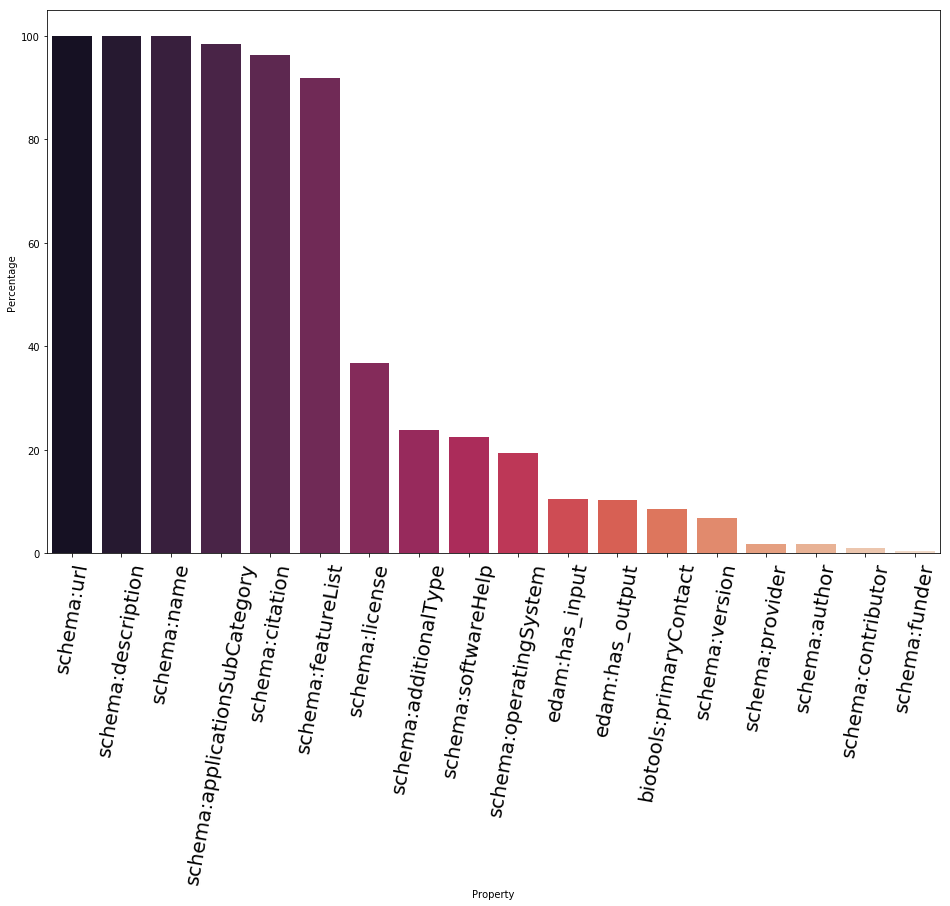

In [31]:
plt.figure(figsize=(16, 10))
chart = sns.barplot(x=df['Property'], y=df['Percentage'], palette="rocket")
chart.set_xticklabels(chart.get_xticklabels(), rotation=80, size=20)